In [1]:
import re
import string
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.decomposition import TruncatedSVD, PCA


from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, clone


In [2]:
dataset_train = pd.read_csv("./train_set_preprocessed.csv")
dataset_train = dataset_train.fillna('')


### Naive conversion to true/false 

In [3]:
def set_is_helpful(row):
    if row["rates_count"] > 0 and row["helpful_count"] > 0 and (row['helpful_count'] / row['rates_count']) > 0.5:
        return "true"
    return "false"

dataset_with_label = dataset_train.copy()
dataset_with_label['is_helpful'] = dataset_train.apply(lambda row: set_is_helpful(row), axis=1)
#dataset_with_label.drop(["rates_count", "helpful_count"], axis=1, inplace=True)


In [4]:
dataset_with_label.is_helpful.value_counts()

true     19512
false     8911
Name: is_helpful, dtype: int64

array([<AxesSubplot:title={'center':'false'}>,
       <AxesSubplot:title={'center':'true'}>], dtype=object)

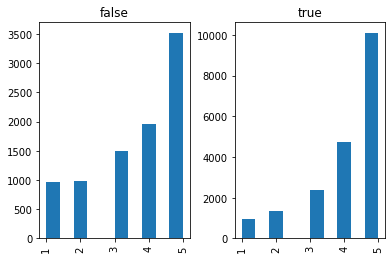

In [5]:
dataset_with_label.hist(column='rating', by='is_helpful')

In [6]:
dataset_balanced = pd.concat(
    (
        dataset_with_label[dataset_with_label.is_helpful == "true"].sample(frac=0.6, random_state=42), 
        dataset_with_label[dataset_with_label.is_helpful == "false"]
    )
)


In [7]:
dataset_balanced.is_helpful.value_counts()


true     11707
false     8911
Name: is_helpful, dtype: int64

### Train/dev split  

In [8]:
X_train, \
X_dev, \
y_train, \
y_dev = train_test_split(
    dataset_balanced.drop(columns=["is_helpful"]), 
    dataset_balanced["is_helpful"], 
    test_size=0.33, 
    random_state=42,
)


In [9]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)

['false' 'true'] [5980 7834]


## 0. Useful selectors (From BLU09)


In [10]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[[self.key]]

In [11]:
def get_and_print_metrics_helpful(true_labels, predictions):
    precision = precision_score(true_labels, predictions, pos_label="true")
    recall = recall_score(true_labels, predictions, pos_label="true")
    f1 = f1_score(true_labels, predictions, pos_label="true")

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    return precision, recall, f1


## 1. Majority class


In [12]:
y_pred = pd.Series(["true"]).repeat(len(X_dev))
precision ,recall, f1 = get_and_print_metrics_helpful(y_dev, y_pred)


Precision: 0.5692239858906526
Recall: 1.0
F1-Score: 0.7254846867097499


## 2. Pure numerical baseline


In [22]:
numerical_columns = [
#     'len_review', 
#     'len_summary', 
#     'word_count_summary', 
#     'word_count_review', 
#     'punctuation_count_summary',
#     'punctuation_count_review',
    'rating',
#     'review_ADJ_count',  # -> interesting bump in precision can be a good indicator we'll not de-generate to majority
]

numeric_steps = []
for feature in numerical_columns:
    pipeline_step = Pipeline(
        [
            (feature, NumberSelector(feature)),
            (f'scaled_{feature}', StandardScaler())
        ]
    )
    numeric_steps.append((feature, pipeline_step))

features_step = FeatureUnion(numeric_steps)

numeric_pipeline = Pipeline([
    ('features', features_step),
    ('classifier', RandomForestClassifier(random_state=42)), # eg. try also DecisionTreeClassifier()

])

numeric_pipeline_run = clone(numeric_pipeline)
numeric_pipeline_run.fit(X_train, y_train)
y_pred_dev = numeric_pipeline_run.predict(X_dev)



In [23]:
print("---- Metrics ----")
precision ,recall, f1 = get_and_print_metrics_helpful(y_dev, y_pred_dev)

unique, counts = np.unique(y_pred_dev, return_counts=True)
print("\n---- Balance ----")
print(unique, counts)

---- Metrics ----
Precision: 0.6748318924111432
Recall: 0.7255357603924606
F1-Score: 0.6992658952345403

---- Balance ----
['false' 'true'] [2640 4164]


## 3. Pure text baseline


In [15]:
summary = Pipeline([
                ('selector', TextSelector("summaryPreprocessed")),
                ('tfidf', TfidfVectorizer())
            ])

review = Pipeline([
                ('selector', TextSelector("reviewTextPreprocessed")),
                ('tfidf', TfidfVectorizer())
            ])

features_step = FeatureUnion([('summary', summary), ('review', review)])

text_pipeline = Pipeline([
    ('features', features_step),
    ('classifier', RandomForestClassifier(max_depth=10, random_state=42)),  # eg. try also MultinomialNB()
])

text_pipeline_run = clone(text_pipeline)
text_pipeline_run.fit(X_train, y_train)
y_pred_dev = text_pipeline_run.predict(X_dev)


In [16]:
print("---- Metrics ----")
precision ,recall, f1 = get_and_print_metrics_helpful(y_dev, y_pred_dev)

unique, counts = np.unique(y_pred_dev, return_counts=True)
print("\n---- Balance ----")
print(unique, counts)

---- Metrics ----
Precision: 0.6245665267384559
Recall: 0.8835528014459075
F1-Score: 0.7318220701454234

---- Balance ----
['false' 'true'] [1325 5479]


## 4. Combining both


In [17]:
combined_steps = numeric_steps + [('summary', summary), ('review', review)]
combined_features = FeatureUnion(combined_steps)

combined_pipeline = Pipeline([
    ('features', combined_features),
    ('classifier', RandomForestClassifier(max_depth=10, random_state=42)),
])

combined_pipeline_run = clone(combined_pipeline)
combined_pipeline_run.fit(X_train, y_train)
y_pred_dev = combined_pipeline_run.predict(X_dev)


In [18]:
print("---- Metrics ----")
precision ,recall, f1 = get_and_print_metrics_helpful(y_dev, y_pred_dev)

unique, counts = np.unique(y_pred_dev, return_counts=True)
print("\n---- Balance ----")
print(unique, counts)

---- Metrics ----
Precision: 0.6260473588342441
Recall: 0.887425768138394
F1-Score: 0.7341663996582293

---- Balance ----
['false' 'true'] [1314 5490]


## 5. Finding useful data


In [19]:
min_rate = 2
df_train = pd.concat((X_train, pd.Series(y_train, name="is_helpful")), axis=1)


In [20]:
#for min_rate in [1, 2, 3, 5, 10]: # -> notice drop in precision even though f1 goes up!
df_train_filtered = df_train[df_train.rates_count > min_rate]

X_train_filtered = df_train_filtered.drop(columns=["is_helpful"])
y_train_filtered = df_train_filtered[["is_helpful"]]
print(f'Min rate {min_rate}. Got {len(X_train_filtered)} samples')

min_rate_combined_pipeline_run = clone(combined_pipeline)
min_rate_combined_pipeline_run.fit(X_train_filtered, y_train_filtered)
y_pred_dev = min_rate_combined_pipeline_run.predict(X_dev)

print("---- Metrics ----")
precision ,recall, f1 = get_and_print_metrics_helpful(y_dev, y_pred_dev)

unique, counts = np.unique(y_pred_dev, return_counts=True)
print("\n---- Balance ----")
print(unique, counts)


Min rate 2. Got 7309 samples
---- Metrics ----
Precision: 0.5737045860631328
Recall: 0.994836044410018
F1-Score: 0.7277363301539334

---- Balance ----
['false' 'true'] [  88 6716]


## Submitting best model

How would it transfer to the test set?

We'll go with combined since it looked best so far (both precision and f1-score)

In [24]:
dataset_held_out_test = pd.read_csv("./test_set_preprocessed.csv", dtype={"is_helpful": str})
dataset_held_out_test = dataset_held_out_test.fillna('')

dataset_held_out_test_labels = pd.read_csv("../portal/data", dtype={"is_helpful": str})

# Combined 
y_pred_test = numeric_pipeline_run.predict(dataset_held_out_test)

print("---- Metrics ----")
precision ,recall, f1 = get_and_print_metrics_helpful(dataset_held_out_test_labels.is_helpful, y_pred_test)

print("\n---- Balance ----")
unique, counts = np.unique(y_pred_test, return_counts=True)
print(unique, counts)

---- Metrics ----
Precision: 0.660857908847185
Recall: 0.61625
F1-Score: 0.6377749029754203

---- Balance ----
['false' 'true'] [1254  746]
